In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from btc_cycles import Bitcoin
from btc_cycles.core.halvings import Halvings, get_halving_data

In [3]:
btc = Bitcoin()

In [4]:
get_halving_data()

(datetime.datetime(2028, 3, 15, 17, 20, 22, tzinfo=datetime.timezone.utc),
 1050000)

In [5]:
Halvings().data

,block,reward,Date,cycle_length,cycle_id
0,0,50,2009-01-03 00:00:00+00:00,1425.0,1
1,210000,25.0,2012-11-28 00:00:00+00:00,1319.0,2
2,420000,12.5,2016-07-09 00:00:00+00:00,1402.0,3
3,630000,6.25,2020-05-11 00:00:00+00:00,1440.0,4
4,840000,3.125,2024-04-20 12:09:27+00:00,1425.0,5
5,1050000,1.5625,2028-03-15 17:20:22+00:00,NaN,6
6,1260000,0.78125,NaT,NaN,7
7,1470000,0.390625,NaT,NaN,8
8,1680000,0.195312,NaT,NaN,9
9,1890000,0.097656,NaT,NaN,10


In [6]:
btc.prices

,Date,Close,block,reward,cycle_length,cycle_id,Halving,ATH,distance_ath_perc,cycle_progress
0,2013-04-28 00:00:00+00:00,127.954255,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,127.954255,0.000000,0.114481
1,2013-04-29 00:00:00+00:00,144.539993,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,0.000000,0.115239
2,2013-04-30 00:00:00+00:00,139.000000,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,-0.038328,0.115997
3,2013-05-01 00:00:00+00:00,116.989998,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,-0.190605,0.116755
4,2013-05-02 00:00:00+00:00,105.209999,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,-0.272105,0.117513
...,...,...,...,...,...,...,...,...,...,...
4008,2024-04-18 00:00:00+00:00,63512.753495,630000.0,6.250,1440.0,4.0,2020-05-11 00:00:00+00:00,73083.501328,-0.130956,0.998611
4009,2024-04-19 00:00:00+00:00,63843.568502,630000.0,6.250,1440.0,4.0,2020-05-11 00:00:00+00:00,73083.501328,-0.126430,0.999306
4010,2024-04-20 00:00:00+00:00,64994.440068,630000.0,6.250,1440.0,4.0,2020-05-11 00:00:00+00:00,73083.501328,-0.110682,1.000000
4011,2024-04-21 00:00:00+00:00,64926.643212,840000.0,3.125,1425.0,5.0,2024-04-20 12:09:27+00:00,73083.501328,-0.111610,0.000000


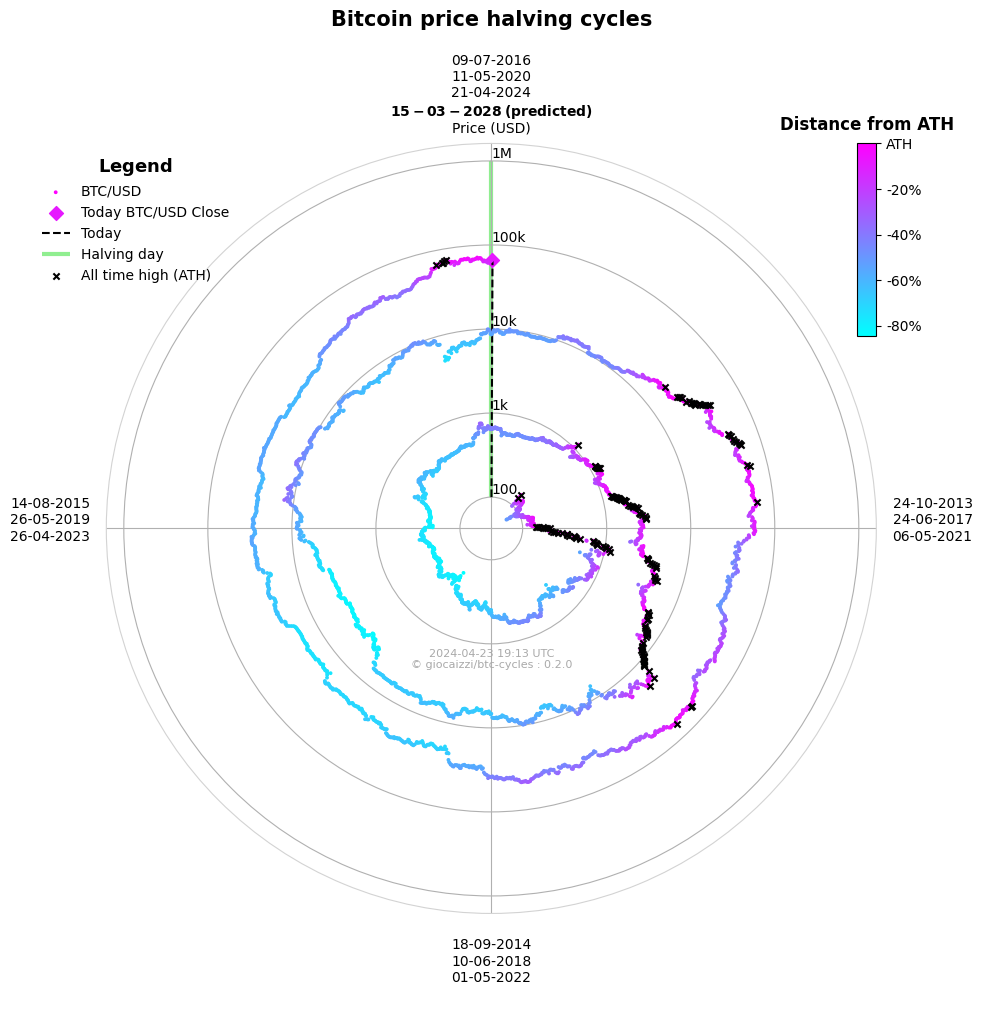

In [7]:
fig = btc.plot()
# # fig is a matplotlib figure object
fig.savefig("bitcoin.png")